In [1]:
import nltk
import matplotlib.pyplot as plt
from nltk.corpus import sentiwordnet as swn
import math
from math import exp, expm1, log, log10
import numpy as np
import turtle
import pandas as pd
from nltk.wsd import lesk
from pycorenlp import StanfordCoreNLP
from pywsd.lesk import simple_lesk
from nltk.corpus import stopwords
stopWords = set(stopwords.words('english'))
import sys, os


nlp = StanfordCoreNLP('http://localhost:9000')
dependency_parser = nlp.annotate

Warming up PyWSD (takes ~10 secs)... took 4.654684782028198 secs.


In [2]:
positive_lexicon = []
negative_lexicon = []

def read_lexicon():
    global positive_lexicon;
    global negative_lexicon;
    
    with open(os.path.join(os.path.abspath('../opinion-lexicon-English/') , 'positive-words.txt'), 'r') as file:
        line = file.readline();
        while ";" in line:
            line = file.readline();
         
        positive_lexicon = file.readlines()
    
    with open(os.path.join(os.path.abspath('../opinion-lexicon-English/') , 'negative-words.txt'), 'r', encoding = "ISO-8859-1") as file:
        line = file.readline();
        while ";" in line:
            line = file.readline();
        
        negative_lexicon = file.readlines()
        
    positive_lexicon = list(map(lambda word: word.rstrip("\n\r"), positive_lexicon))
    negative_lexicon = list(map(lambda word: word.rstrip("\n\r"), negative_lexicon))
    
        
read_lexicon()
op_set = positive_lexicon + negative_lexicon

negation = [
    "afraid",
    "can't",
    "cannot",
    "deny",
    "mean",
    "negate",
    "negation",
    "negative",
    "neither",
    "never",
    "no",
    "non",
    "none",
    "nor",
    "not",
    "nothing",
    "refusal",
    "refuse",
    "reject",
    "rejection"
]

In [3]:
def analyse_file(key, filename):
    try:
        file = open(filename, 'r')
    except (BaseExceptionException,e):
        print ('Invalid File!')
        return 'Error'  
    doc = file.read()
    lines = doc.lower().split("\n")
    file.close()
    
    radii = get_TDOC(lines, key)    
    return radii, lines

def get_TDOC(lines, key):
    freq = {'Init': 0}              #Number of times context term occurs with key
    freq.clear()
    prohib = ['']#stopWords
    for line in lines:
        words = line.split(" ")
        if key in words:
            for context in words:
                flag=0
                for i in prohib:
                    if i == context:
                        flag=1
                        break
                if flag==0 and context!=key and context in op_set:
                    freq.setdefault(context, 0)
                    freq[context] = freq.get(context) + 1
                                           
    N = 0                           #Total Number of terms in Document
    for line in lines:
        words = line.split(" ")
        N += len(words)

    Nci = {'Init': 0}               #Total terms that occur with context term
    Nci.clear()
    for context in freq.keys():
        for line in lines:
            words = line.split(" ")
            if context in words:
                Nci.setdefault(context, 0)
                Nci[context] += len(words)

    radii = {'Init': 0}             #Get Radius of context term with TDOC formula
    radii.clear()
    
    df = pd.DataFrame(columns=['c', 'm', 'N', 'Nc', 'f', 'N/Nc', 'log(N/Nc)', 'fxlog(N/Nc)', '/4'])
    max_value = 0
    for term in freq.keys():
        radii[term] = (freq[term]*(log(N/Nci[term])))
        
        if radii[term] > max_value:
            max_value = radii[term]
        
    for term in freq.keys():
        radii[term] = radii[term]/max_value
        
        df = df.append({'c': term,
                'm': key,
                'N': N,
                'Nc': Nci[term],
                'f': freq[term],
                'N/Nc': "{0:.2f}".format(N/Nci[term]),
                'log(N/Nc)': "{0:.2f}".format(log(N/Nci[term])),
                'fxlog(N/Nc)': "{0:.2f}".format(freq[term]*(log(N/Nci[term]))),
                'normalisasi': "{0:.2f}".format((freq[term]*(log(N/Nci[term])))/max_value)
               }, ignore_index=True)
    
#     df.to_excel("tdoc2.xlsx")
    return radii                    #Returns entire set of context terms related to key

def pos_tag(sentence):
    result = dependency_parser(sentence, properties={"outputFormat": "json", "annotators": "pos"})['sentences'][0]['tokens']
    res = []
    for pos in result:
        res.append((pos['word'], pos['pos']))
    return res

def get_theta(key, sentences):
    scores = []
    for sentence in sentences:
        flag = True
        
        pp_tagged = pos_tag(sentence)
        tagged = ('','')
        for p in pp_tagged:
            if p[0] == key:
                tagged = p
        if tagged == ('', ''):
            flag = False
        
        ambiguous = tagged[0]
        tag = tagged[1]
        pos = ''

        if 'NN' in tag:
            pos = 'n'
        elif 'NNS' in tag:
            pos = 'nns'
        elif 'VB' in tag:
            pos = 'v'
        elif 'VBG' in tag:
            pos = 'v'
        elif 'JJ' in tag:
            pos = 'a'
        elif 'RB' in tag:
            pos = 'r'
        else:
            flag = False

        if flag:
            answer = simple_lesk(sentence, ambiguous, pos)
            if answer:
                score = swn.senti_synset(answer.name())
                endscore = 0
                
                if score.pos_score() > score.neg_score():
                    endscore = score.pos_score()
                else:
                    endscore = score.neg_score() * (-1)
#                     endscore = score.obj_score()*(-1)
                
                words = sentence.split(' ')
                word_around = []
                for x in range(0, len(words)):
                    try:
                        if (words[x+1] == key) or (words[x+2] == key) or (words[x+3]== key):
                            word_around.append(words[x])
                        elif (words[x-1] == key) or (words[x-2] == key) or (words[x-3]== key):
                            word_around.append(words[x])
                    except:
                        pass
                    
                for neg in negation:
                    if neg in word_around:
                        endscore *= (-1)
                        break
                        
                scores.append(endscore)
            else:
                scores.append(0)
        else:
            scores.append(0)
            
    final_score = np.average(scores)
    return np.pi * final_score

In [4]:
def prior_sentiment(radii, key, all_sentences):
    theta = {'Init': 0}
    theta.clear()
    for word in radii.keys():
        sentences = []
        for sentence in all_sentences:
            words = sentence.split(' ')
            if (word in words) and (key in words):
                sentences.append(sentence)
        
#         print(word, len(sentences))
        filter = get_theta(word, sentences)            #if function returns 0 word does not exist in lexicon
        theta[word] = filter
        
    return theta

In [5]:
def graph(radii, theta, key):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    plt.plot([0,0],[-1,1])
    plt.plot([-1,1],[0,0])
    plt.axis([-1,1,-1,1])
    i=0
    a=[]
    b=[]
    rad=list(radii.values())
    theta1=list(theta.values())

    while(i<len(radii)):
        a.append(rad[i]*math.cos(theta1[i]))
        b.append(rad[i]*math.sin(theta1[i]))
        i+=1 
    plt.scatter(a,b,label="circles",color="r",marker="o",s=10)
    q = 0
    rad2=list(radii.keys())
    for i,j in zip(a,b):
        ax.annotate('%s' %rad2[q], xy=(i,j), xytext=(15,0), textcoords='offset points')
        q = q+1    

    ax.add_artist(plt.Circle((0,0),1.0,color='b',fill=False))
    plt.xlabel('Sentiment Strength')
    plt.ylabel('Orientation')
    plt.title(key)
    plt.savefig("graph.png")

In [6]:
def senti(key, filename):
    radii, lines = analyse_file(key, filename)
    theta = prior_sentiment(radii, key, lines)
    graph(radii, theta, key)
#     return theta

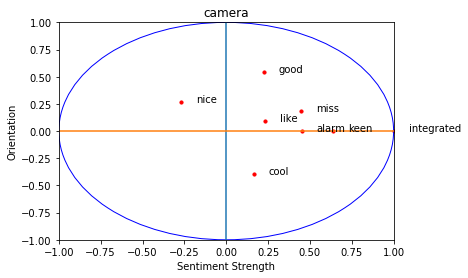

In [14]:
senti('camera', 'nokia.txt')

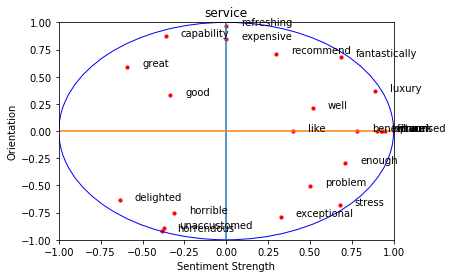

In [15]:
senti('service', 'nokia.txt')

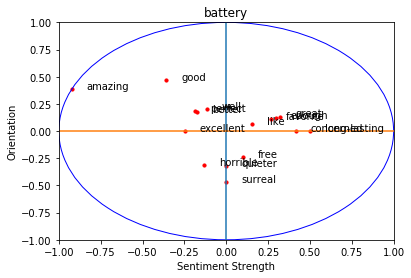

In [17]:
senti('battery', 'nokia.txt')

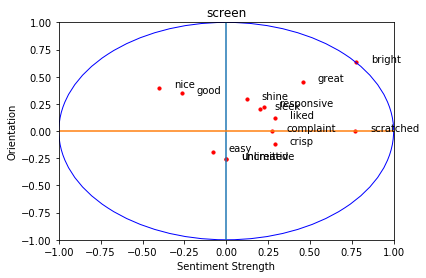

In [18]:
senti('screen', 'nokia.txt')

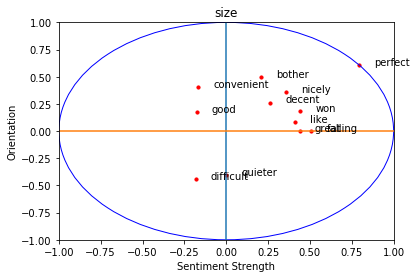

In [23]:
senti('size', 'nokia.txt')

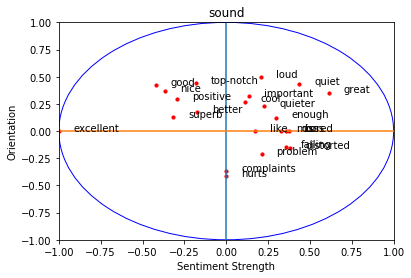

In [24]:
senti('sound', 'nokia.txt')

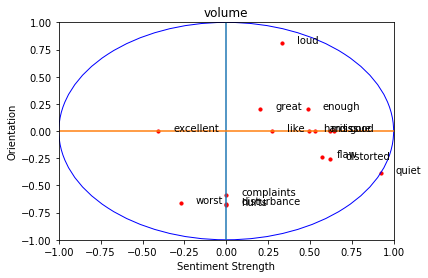

In [25]:
senti('volume', 'nokia.txt')